# Experiment Workbench

In [44]:
import os, sys, math, datetime
import pathlib
from pathlib import Path
import numpy as np
import random
from matplotlib import pyplot as plt
import PIL
import PIL.Image
import seaborn as sns

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D,DepthwiseConv2D, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D, BatchNormalization, Concatenate
from tensorflow.keras.layers import ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
 
# Import the necessary MLTK APIs
from mltk.core import view_model, summarize_model, profile_model

# import workbench.config.config
from workbench.config.config import initialize
from workbench.utils.utils import create_filepaths
from workbench.utils.utils import parse_model_name

#from dotenv import load_dotenv
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint
#import deeplake


In [3]:
print("Tensorflow version " + tf.__version__)
AUTOTUNE = tf.data.AUTOTUNE

# Confirm that TensorFlow can access GPU
device_name = tf.test.gpu_device_name()
if not device_name:
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.10.0
Found GPU at: /device:GPU:0


In [4]:
# TODO:

# Add learning rate schedule

# tf.compat.v1.disable_eager_execution()

In [5]:
# DANGER ZONE: Disable warning messages

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [6]:


# set the random seeds
os.environ["TF_CUDNN_DETERMINISTIC"]= "1"
random.seed(hash("setting_random seeds") % 2**32 -1)
np.random.seed(hash("improves reproducibility") % 2**32 -1)
tf.random.set_seed(hash("by removing stochasticity") %2 *32 -1 )

In [7]:
models_dir = initialize()

# Get the model

In [8]:
global model_name
model_name = "mobilenetv1_0.25_96_c3_o3_l1"

In [9]:
models_path, models_summary_path, models_image_path, models_layer_df_path, models_tf_path, models_tflite_path, models_tflite_opt_path = create_filepaths(model_name)

i:\tinyml\tiny_cnn\models


In [10]:
model = keras.models.load_model(models_tf_path)

In [11]:
global base_model_name
global alpha
global resolution
global channels
global classes
global variation
global early_stopping_patience

In [12]:
base_model_name, alpha, resolution, channels, classes, variation = model_name.split("_")

In [13]:
alpha = float(alpha)
resolution = int(resolution)
classes = int(classes.strip("o"))

In [14]:
# Start a Tensorboard session
%load_ext tensorboard

In [15]:
#os.environ['WANDB_NOTEBOOK_NAME'] = 'Experiment Workbench'

IMG_HEIGHT = resolution
IMG_WIDTH = resolution
BATCH_SIZE = 32
EPOCHS = 30
#LOGGING_STEPS = 64
MOMENTUM = 0.9
LR = 0.001
DROPOUT = 0.5
early_stopping_patience = 30

#PROJECT = base_model_name
PROJECT = "tiny_cnn troubleshooting"
SEED = 42
tf.random.set_seed(SEED) # global seed for tensorflow random parts, like dropout
shuffle_seed = 42

# Prepare the Lemon Quality Dataset

In [16]:
dataset_path = Path.cwd().joinpath("datasets", "lemon_dataset")
dataset_path.exists()

True

In [17]:
def get_lemon_quality_dataset(dataset_path, img_width, img_height, batch_size, normalize=True):
    """ Fetches the lemon quality dataset and prints dataset info. It normalizes the image data to range [0,1] by default.

    Args: 
        dataset_path (Path): the file location of the dataset. Subfolders "train", "test", and "val" are expected.
        normalize (boolean): Normalizes the image data to range [0, 1]. Default: True

    Returns:
        (train_ds, val_ds, test_ds, class_names) (tuple(tf.datasets)): Tensorflow datasets for train, validation and test.
    
    """
    if dataset_path.exists():
        try:
            train_dir = dataset_path.joinpath("train")
            val_dir = dataset_path.joinpath( "val")
            test_dir = dataset_path.joinpath( "test")
        except:
            print(f"Please check the folder structure of {dataset_path}.")
            raise



    # create the labels list to avoid inclusion of .ipynb checkpoints
    #labels = ["bad_quality", "empty_background", "good_quality"]

    print("Preparing training dataset...")        
    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=((img_height, img_width)),
        #labels=labels,
        batch_size=batch_size)
    

    class_names = train_ds.class_names


    print("Preparing validation dataset...")    
    val_ds = tf.keras.utils.image_dataset_from_directory(
        val_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    

    print("Preparing test dataset...")    
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        subset=None,
        seed=shuffle_seed,
        image_size=(img_height, img_width),
        batch_size=batch_size)
    
    # Create a data augmentation stage with horizontal flipping, rotations, zooms
    data_augmentation = keras.Sequential(
        [
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomZoom(0.1),
        ]
        )

    #train_ds= train_ds.map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=tf.data.AUTOTUNE )

    
    # Normalize the data to the range [0, 1]
    if normalize:
        normalization_layer = tf.keras.layers.Rescaling(1./255, offset=-1)

        train_ds= train_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        val_ds= val_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
        test_ds= test_ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    else:
        pass

    print (f"Class names: {class_names}")
    print(train_ds.element_spec)
    print(f"Normalize: {normalize}")
    return (train_ds, val_ds, test_ds, class_names)

In [18]:
train_ds, val_ds, test_ds, labels = get_lemon_quality_dataset(dataset_path, IMG_WIDTH, IMG_HEIGHT, BATCH_SIZE)

Preparing training dataset...
Found 2021 files belonging to 3 classes.
Preparing validation dataset...
Found 252 files belonging to 3 classes.
Preparing test dataset...
Found 255 files belonging to 3 classes.
Class names: ['bad_quality', 'empty_background', 'good_quality']
(TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Normalize: True


In [19]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(32, 96, 96, 3)
(32,)
tf.Tensor([0 2 2 0 2 2 0 1 0 2 1 2 1 1 2 2 2 0 0 0 1 0 2 1 0 0 0 2 0 1 0 0], shape=(32,), dtype=int32)


In [20]:
classes = len(labels)
print(f"The dataset contains {classes } classes.")

The dataset contains 3 classes.


# Define the model

In [21]:
logdir = os.path.join("logs", model_name, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
root_logdir = os.getcwd()

In [22]:
wandb.__version__

'0.13.7'

In [23]:
tf.keras.backend.clear_session()

# optimize the data flow
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().prefetch(AUTOTUNE)
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

In [24]:
os.environ["WANDB_MODE"] = "online"
def train_model_wandb(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        if len(wandb.patched["tensorboard"]) > 0:
                wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # Generate run ids
        id = wandb.util.generate_id()

        run = wandb.init(
                # Set the project where this run will be logged
                project=PROJECT, 
                id = id, 
                resume="allow",
                sync_tensorboard=True
                )

        # Specify the configuration variables
        config = wandb.config
        
        config.batch_size = BATCH_SIZE
        #config.dropout =DROPOUT
        config.learn_rate = LR
        config.momentum = MOMENTUM
        #config.decay = 1e-6
        config.epochs = EPOCHS
        config.classes = classes
        config.id = id
        config.architecture = model_name
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=MOMENTUM)
        config.optimizer = optimizer._name

        model.compile(optimizer=optimizer,
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())
        checkpoint = WandbModelCheckpoint(Path(wandb.run.dir).joinpath(f"checkpoint"),
                monitor="val_accuracy",
                save_best_only=True,
                save_freq="epoch")

        global early_stopping_patience
        early_stopping = EarlyStopping(monitor="val_accuracy", patience=early_stopping_patience)

        #checkpoint = ModelCheckpoint("my_tiny_model", save_weights_only=True)

        callbacks =[
                tensorboard_callback,
                #wandb_callback,
                WandbMetricsLogger(),
                checkpoint,
                early_stopping
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        #scores = model.evaluate(X[test], Y[test], verbose=0)
        wandb.save("last_model.h5")
        # wandb.log({
        #         "loss": history.history["loss"],
        #         "accuracy": history.history["accuracy"],
        #         "val_loss": history.history["val_loss"],
        #         "val_accuracy": history.history["val_accuracy"],                                
        # })
        
        run.finish()
        return history, model

In [25]:
#wandb.finish()
history, model = train_model_wandb(model)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: susbrock. Use `wandb login --relogin` to force relogin


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


Epoch 1/30
64/64 [==============================] - ETA: 0s - loss: 1.0293 - accuracy: 0.4918INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 53s 348ms/step - loss: 1.0293 - accuracy: 0.4918 - val_loss: 1.0610 - val_accuracy: 0.3770
Epoch 2/30
63/64 [============================>.] - ETA: 0s - loss: 0.7172 - accuracy: 0.7083

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 38ms/step - loss: 0.7180 - accuracy: 0.7081 - val_loss: 1.0648 - val_accuracy: 0.3770
Epoch 3/30
64/64 [==============================] - ETA: 0s - loss: 0.4638 - accuracy: 0.8204

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 38ms/step - loss: 0.4638 - accuracy: 0.8204 - val_loss: 1.0874 - val_accuracy: 0.3770
Epoch 4/30
63/64 [============================>.] - ETA: 0s - loss: 0.3363 - accuracy: 0.8705

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 48ms/step - loss: 0.3359 - accuracy: 0.8709 - val_loss: 1.1132 - val_accuracy: 0.3770
Epoch 5/30
63/64 [============================>.] - ETA: 0s - loss: 0.2357 - accuracy: 0.9162

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 44ms/step - loss: 0.2391 - accuracy: 0.9154 - val_loss: 1.1204 - val_accuracy: 0.3770
Epoch 6/30
64/64 [==============================] - ETA: 0s - loss: 0.2035 - accuracy: 0.9302

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 2s 37ms/step - loss: 0.2035 - accuracy: 0.9302 - val_loss: 1.1704 - val_accuracy: 0.3770
Epoch 7/30
63/64 [============================>.] - ETA: 0s - loss: 0.1750 - accuracy: 0.9375

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 42ms/step - loss: 0.1757 - accuracy: 0.9367 - val_loss: 1.2993 - val_accuracy: 0.3611
Epoch 8/30
63/64 [============================>.] - ETA: 0s - loss: 0.1497 - accuracy: 0.9494INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 14s 219ms/step - loss: 0.1494 - accuracy: 0.9495 - val_loss: 1.1988 - val_accuracy: 0.5238
Epoch 9/30
62/64 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9612INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 10s 164ms/step - loss: 0.1239 - accuracy: 0.9619 - val_loss: 0.5085 - val_accuracy: 0.8135
Epoch 10/30
62/64 [============================>.] - ETA: 0s - loss: 0.1107 - accuracy: 0.9617INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 10s 152ms/step - loss: 0.1105 - accuracy: 0.9619 - val_loss: 0.2999 - val_accuracy: 0.9048
Epoch 11/30
63/64 [============================>.] - ETA: 0s - loss: 0.0840 - accuracy: 0.9722INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 11s 171ms/step - loss: 0.0858 - accuracy: 0.9713 - val_loss: 0.1473 - val_accuracy: 0.9444
Epoch 12/30
63/64 [============================>.] - ETA: 0s - loss: 0.1013 - accuracy: 0.9633

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 4s 55ms/step - loss: 0.1011 - accuracy: 0.9634 - val_loss: 0.1866 - val_accuracy: 0.9206
Epoch 13/30
63/64 [============================>.] - ETA: 0s - loss: 0.0830 - accuracy: 0.9742

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 42ms/step - loss: 0.0838 - accuracy: 0.9733 - val_loss: 0.3098 - val_accuracy: 0.9008
Epoch 14/30
63/64 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9697INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 10s 152ms/step - loss: 0.0907 - accuracy: 0.9693 - val_loss: 0.1158 - val_accuracy: 0.9524
Epoch 15/30
63/64 [============================>.] - ETA: 0s - loss: 0.0711 - accuracy: 0.9812

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 2s 36ms/step - loss: 0.0712 - accuracy: 0.9812 - val_loss: 0.1538 - val_accuracy: 0.9365
Epoch 16/30
63/64 [============================>.] - ETA: 0s - loss: 0.0532 - accuracy: 0.9821

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 42ms/step - loss: 0.0535 - accuracy: 0.9822 - val_loss: 0.3659 - val_accuracy: 0.8730
Epoch 17/30
63/64 [============================>.] - ETA: 0s - loss: 0.0500 - accuracy: 0.9856

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 50ms/step - loss: 0.0509 - accuracy: 0.9852 - val_loss: 0.1606 - val_accuracy: 0.9365
Epoch 18/30
62/64 [============================>.] - ETA: 0s - loss: 0.0639 - accuracy: 0.9788

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 51ms/step - loss: 0.0689 - accuracy: 0.9782 - val_loss: 0.1457 - val_accuracy: 0.9444
Epoch 19/30
63/64 [============================>.] - ETA: 0s - loss: 0.0690 - accuracy: 0.9762

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 50ms/step - loss: 0.0690 - accuracy: 0.9762 - val_loss: 0.1720 - val_accuracy: 0.9444
Epoch 20/30
62/64 [============================>.] - ETA: 0s - loss: 0.0491 - accuracy: 0.9859

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 5s 78ms/step - loss: 0.0514 - accuracy: 0.9852 - val_loss: 0.2142 - val_accuracy: 0.9206
Epoch 21/30
62/64 [============================>.] - ETA: 0s - loss: 0.0865 - accuracy: 0.9713

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 4s 55ms/step - loss: 0.0866 - accuracy: 0.9713 - val_loss: 0.1708 - val_accuracy: 0.9365
Epoch 22/30
62/64 [============================>.] - ETA: 0s - loss: 0.0523 - accuracy: 0.9829INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 11s 172ms/step - loss: 0.0523 - accuracy: 0.9827 - val_loss: 0.1185 - val_accuracy: 0.9563
Epoch 23/30
63/64 [============================>.] - ETA: 0s - loss: 0.0450 - accuracy: 0.9856

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 47ms/step - loss: 0.0449 - accuracy: 0.9857 - val_loss: 0.2392 - val_accuracy: 0.9246
Epoch 24/30
63/64 [============================>.] - ETA: 0s - loss: 0.0329 - accuracy: 0.9926INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 9s 141ms/step - loss: 0.0332 - accuracy: 0.9926 - val_loss: 0.1399 - val_accuracy: 0.9643
Epoch 25/30
63/64 [============================>.] - ETA: 0s - loss: 0.0279 - accuracy: 0.9950

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 4s 68ms/step - loss: 0.0279 - accuracy: 0.9951 - val_loss: 0.2726 - val_accuracy: 0.9127
Epoch 26/30
64/64 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9921

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 2s 37ms/step - loss: 0.0270 - accuracy: 0.9921 - val_loss: 0.3398 - val_accuracy: 0.9008
Epoch 27/30
62/64 [============================>.] - ETA: 0s - loss: 0.0397 - accuracy: 0.9849

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 4s 59ms/step - loss: 0.0391 - accuracy: 0.9852 - val_loss: 0.1161 - val_accuracy: 0.9563
Epoch 28/30
63/64 [============================>.] - ETA: 0s - loss: 0.0282 - accuracy: 0.9926INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets


INFO:tensorflow:Assets written to: i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint\assets
wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 11s 166ms/step - loss: 0.0281 - accuracy: 0.9926 - val_loss: 0.0744 - val_accuracy: 0.9683
Epoch 29/30
62/64 [============================>.] - ETA: 0s - loss: 0.0302 - accuracy: 0.9924

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 3s 44ms/step - loss: 0.0298 - accuracy: 0.9926 - val_loss: 0.1654 - val_accuracy: 0.9603
Epoch 30/30
63/64 [============================>.] - ETA: 0s - loss: 0.0310 - accuracy: 0.9916

wandb: Adding directory to artifact (i:\tinyml\tiny_cnn\wandb\run-20221217_183110-21dc65ra\files\checkpoint)... Done. 0.0s


64/64 [==============================] - 2s 37ms/step - loss: 0.0310 - accuracy: 0.9916 - val_loss: 0.1142 - val_accuracy: 0.9563


epoch/accuracy,▁▄▆▆▇▇▇▇██████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▃▆▇█▇▇██▇███▇██▇█▇▇████
epoch/val_loss,▇▇▇▇▇▇█▇▃▂▁▂▂▁▁▃▁▁▂▂▂▁▂▁▂▃▁▁▂▁
epoch/accuracy,0.99159
epoch/epoch,29
epoch/learning_rate,0.001
epoch/loss,0.03095
epoch/val_accuracy,0.95635


In [32]:
scores = model.evaluate(val_ds, verbose=0)

In [33]:
scores

[0.11417687684297562, 0.9563491940498352]

In [35]:
model.metrics_names

['loss', 'accuracy']

In [36]:
val_predictions = model.predict(val_ds)

8/8 [==============================] - 1s 6ms/step


In [38]:
top_pred_ids = val_predictions.argmax(axis=1)

In [41]:
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_true

array([0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 0, 2, 0, 1,
       1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 2, 0,
       2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       2, 1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 0, 0, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0, 0, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 0,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2,
       1, 2, 0, 2, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 2, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 0])

In [43]:
confusion_mtx = tf.math.confusion_matrix(y_true, top_pred_ids, num_classes=classes)
    # list(ds_test.map(lambda x, y: y)),
    # predict_class_label_number(test_data),
    # num_classes=len(label_names))
    
confusion_mtx

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[ 90,   0,   5],
       [  0,  45,   0],
       [  6,   0, 106]])>

In [54]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(6, 6))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

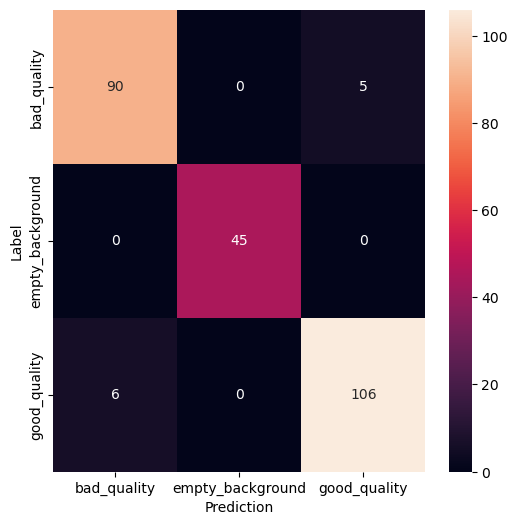

In [55]:
show_confusion_matrix(confusion_mtx, labels)

In [39]:
top_pred_ids

array([0, 0, 1, 2, 0, 1, 2, 1, 2, 2, 2, 2, 2, 0, 2, 0, 2, 1, 0, 2, 0, 1,
       1, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 2, 0,
       2, 2, 2, 0, 1, 0, 1, 0, 0, 2, 0, 2, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0,
       2, 1, 2, 2, 1, 1, 0, 2, 1, 0, 2, 0, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2,
       0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 1, 1, 1, 1, 2, 0, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 2,
       0, 1, 2, 1, 2, 2, 2, 1, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 0, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 1, 0, 2, 2, 1, 1, 2, 0, 2,
       1, 2, 0, 0, 2, 2, 0, 0, 0, 2, 1, 0, 0, 0, 2, 2, 0, 1, 2, 0, 2, 2,
       1, 0, 2, 2, 2, 2, 1, 2, 0, 2, 2, 2, 0, 0, 2, 0, 2, 0, 0, 0, 0, 2,
       2, 0, 0, 0, 1, 2, 0, 2, 0, 2, 0, 0, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2,
       2, 0, 2, 1, 2, 2, 2, 1, 2, 0], dtype=int64)

In [37]:
val_predictions

array([[9.95561838e-01, 7.05273647e-04, 3.73282470e-03],
       [9.98225391e-01, 5.83289773e-04, 1.19132141e-03],
       [9.97980387e-05, 9.99885798e-01, 1.44446121e-05],
       [1.18365183e-01, 6.67219923e-04, 8.80967617e-01],
       [9.99765337e-01, 1.15217001e-04, 1.19466837e-04],
       [1.70197891e-05, 9.99951959e-01, 3.10144824e-05],
       [3.51684008e-07, 3.40556630e-06, 9.99996185e-01],
       [2.15740351e-04, 9.99723375e-01, 6.08458031e-05],
       [7.02340117e-07, 1.15522096e-06, 9.99998093e-01],
       [2.92806590e-07, 5.16962302e-07, 9.99999166e-01],
       [8.14303197e-03, 1.85876642e-03, 9.89998162e-01],
       [4.81847644e-01, 2.98996340e-03, 5.15162349e-01],
       [5.19866153e-05, 6.37105186e-05, 9.99884248e-01],
       [9.88050818e-01, 3.99181386e-03, 7.95733463e-03],
       [4.38374095e-02, 2.75948807e-03, 9.53403115e-01],
       [7.78344870e-01, 1.92776532e-03, 2.19727397e-01],
       [1.87569812e-01, 3.11256200e-03, 8.09317648e-01],
       [1.59106893e-03, 9.97962

## Code reserved for troubleshooting

In [26]:
def mobilenet_v1_keras(input_shape, classes=classes, alpha=alpha):
    model = tf.keras.applications.mobilenet.MobileNet(
        input_shape=input_shape,
        alpha=alpha,
        depth_multiplier=1,
        dropout=0.001,
        include_top=True,
        weights=None, #'imagenet'
        input_tensor=None,
        pooling=None,
        classes=classes,
        classifier_activation='softmax',
        #**kwargs
    )

    #model._name = model.name + "_keras" # model.name cannot be overritten

    return model
    #model = mobilenet_v1_keras((IMG_WIDTH, IMG_HEIGHT, 3), classes=classes, alpha=alpha)

In [27]:
#os.environ["WANDB_MODE"] = "online"
def train_model(model):

        # solve issue from: https://github.com/wandb/wandb/issues/3536
        # if len(wandb.patched["tensorboard"]) > 0:
        #         wandb.tensorboard.unpatch()
                
        # Configure Tensorboard root log directory to read the debugging information
        #wandb.tensorboard.patch(root_logdir=root_logdir)
        # wandb.tensorboard.patch(root_logdir="wandb.run.dir")
        
        # wandb.init(
        #         # Set the project where this run will be logged
        #         project=PROJECT, 
        #         # Track hyperparameters and run metadata
        #         #config={
        #         #"learning_rate": LR,
        #         #"epochs": EPOCHS,
        #         #},
        #         sync_tensorboard=True
        #         )



        # config = wandb.config
        # # Specify the configuration variables
        # config.batch_size = BATCH_SIZE
        # config.dropout =DROPOUT
        # config.learn_rate = LR
        # #config.decay = 1e-6
        # #config.momentum = 0.9
        # config.epochs = EPOCHS
        # config.classes = classes
        

        # enable Tensorflow Debugging
        #tf.debugging.experimental.enable_dump_debug_info("./logs/debug", 
        #        tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

        #model = mobilenet
        model.compile(optimizer='adam',
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

        logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
        #tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= wandb.run.dir, histogram_freq=10, update_freq="epoch") #, profile_batch="10, 20")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir= logdir) #, histogram_freq=1)
        #wandb_callback = WandbCallback()# input_type="image", labels=labels) #, validation_data = val_ds.as_numpy_iterator())

        early_stopping = EarlyStopping(monitor="val_accuracy", patience=50)

        #checkpoint = ModelCheckpoint("my_tiny_model", save_weights_only=True)

        callbacks =[
                #tensorboard_callback,
                #wandb_callback,
                #WandbMetricsLogger(),
                #checkpoint,
                #early_stopping
        ]

        history = model.fit(train_ds,
                epochs=EPOCHS, 
                validation_data=val_ds, 
                callbacks=callbacks
        )

        # wandb.log({
        #         "loss": history.history["loss"],
        #         "accuracy": history.history["accuracy"],
        #         "val_loss": history.history["val_loss"],
        #         "val_accuracy": history.history["val_accuracy"],                                
        # })
        
        #wandb.finish()
        return history, model


In [28]:
# model.compile(optimizer='adam',
#                 loss='sparse_categorical_crossentropy',
#                 metrics=['accuracy'])

In [29]:
# history = model.fit(train_ds,
#                 epochs=EPOCHS, 
#                 validation_data=val_ds
#         )

In [30]:
#history.history["loss"]
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 64}